In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from astropy.io import ascii

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog,FakeSim
from halotools.mock_observables import delta_sigma, wp, return_xyz_formatted_array
from halotools.empirical_models import NFWProfile
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.utils import add_halo_hostid

from scipy.special import erf
#Length units are comoving and assumed to be in Mpc/h, here and throughout Halotools

from astropy.cosmology import Planck15

HOD model to match [Johannes' paper](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.5771L/abstract)

In [ ]:
#create new HOD model. code from Johannes
class IncompleteAssembiasZheng07Cens(AssembiasZheng07Cens):

    def __init__(self, **kwargs):
        AssembiasZheng07Cens.__init__(self, **kwargs)
        self.param_dict['f_compl'] = 1.0

    def mean_occupation(self, **kwargs):
        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            mass = kwargs['table'][self.prim_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            mass = np.atleast_1d(kwargs['prim_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                "to the ``mean_occupation`` function of the ``Zheng07Cens`` class.\n")
            raise HalotoolsError(msg)

        logM = np.log10(mass)
        
        mean_ncen = self.param_dict['f_compl']*0.5*(1.0 + erf(
            (logM - self.param_dict['logMmin']) / self.param_dict['sigma_logM']))

        return mean_ncen

#just need to change the centrals occupation. the rest is the same as Zheng07
def Lange19_HOD_model(redshift, cosmology, secondary_haloprop_key):

    cens_occ_model = IncompleteAssembiasZheng07Cens(threshold=-21.5, redshift=redshift,
                                                    sec_haloprop_key=secondary_haloprop_key)
    cens_prof_model = TrivialPhaseSpace(redshift=redshift, cosmology=cosmology)
    sats_occ_model = AssembiasZheng07Sats(threshold=-21.5, redshift=redshift,
                                          modulate_with_cenocc=True, cenocc_model=cens_occ_model,
                                          sec_haloprop_key=secondary_haloprop_key)
    sats_occ_model._suppress_repeated_param_warning = True
    sats_prof_model = NFWPhaseSpace(redshift=redshift, cosmology=cosmology)

    model = HodModelFactory(
        centrals_occupation=cens_occ_model, centrals_profile=cens_prof_model,
        satellites_occupation=sats_occ_model,
        satellites_profile=sats_prof_model)

    return model

## CMASS data 

In [28]:
data_dir = '/Users/fardila/Documents/GitHub/baryonic_effects/CMASS/data/'

wp_data_file = 'wpNSdebiasedboss5003.txt'
wp_correct_cosmology_data_file = 'wp_cmass_z0.430.70'

ds_data_file = 'cmass_deltasigma_0.43_0.7.txt'

In [29]:
wp_data = ascii.read(data_dir+wp_data_file, names = ['rp','wp','wp_err'])
wp_correct_cosmology_data = ascii.read(data_dir+wp_correct_cosmology_data_file, names = ['rp','wp','wp_err'])

ds_data = ascii.read(data_dir+ds_data_file, names = ['rp','ds','ds_err'])

## simulation: MDPL2 

### load catalogs 

In [58]:
data_directory = '/Users/fardila/Documents/Data/baryonic_effects/CMASS/'
queried_halo_cat_file = 'halo_catalogs/mdpl2_hlist_0.65650_Mvir11.2.csv'
### "row_id","Mvir","Rvir","M200c","M500c","x","y","z","scale"
full_halo_cat_file = 'halo_catalogs/cut_halo_df.pkl'
particle_cat_file = 'particle_catalogs/mdpl2_particles_0.6565_10m.dat'
### "x","y","z"
displacedA_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_A.out'
displacedB_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_B_M14.out'
displacedC_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_C_M14.out'

In [69]:
def create_halo_and_particle_catalogs_for_halotools(halo_catalog_path, particle_catalog_path):
    halo_df = pd.read_csv(halo_catalog_path)
    particles_df = pd.read_csv(particle_catalog_path, delimiter =' +',  names=['x','y','z'], engine='python')
    print('Files read.')
    
    ptcl_x = particles_df['x'].values
    ptcl_y = particles_df['y'].values
    ptcl_z = particles_df['z'].values

    redshift = (1./0.65650)-1. #z=0.523
    Lbox = 1000. #Mpc/h
    particle_mass = 1.51e9
    num_ptcl_per_dim = 3840
    x = halo_df['x'].values
    y = halo_df['y'].values
    z = halo_df['z'].values
    vx = halo_df['vx'].values
    vy = halo_df['vy'].values
    vz = halo_df['vz'].values
    mass = halo_df['Mvir'].values
    radius = halo_df['Rvir'].values/1e3 #convert to Mpc
    ids = np.arange(0, len(halo_df))
    upid = halo_df['upId'].values
    simname = 'MDPL2'
    
    #get concentrations
#     nfw = NFWProfile(redshift=redshift, cosmology = Planck15, mdef = 'vir', conc_mass_model = 'dutton_maccio14')
#     model_conc = nfw.conc_NFWmodel(prim_haloprop = mass)
    concentrations = halo_df['Rvir'].values / halo_df['Rs'].values
    
    print('Creating catalogs...')
    particle_catalog = UserSuppliedPtclCatalog(x = ptcl_x, y = ptcl_y, z = ptcl_z, Lbox = Lbox, particle_mass = particle_mass,
                                  redshift = redshift)
    halo_catalog = UserSuppliedHaloCatalog(user_supplied_ptclcat = particle_catalog, redshift = redshift, simname = simname,
                                       Lbox = Lbox, particle_mass = particle_mass, num_ptcl_per_dim =num_ptcl_per_dim,
                                       halo_x = x, halo_y = y, halo_z = z,
                                       halo_vx = vx, halo_vy = vy, halo_vz = vz, 
                                       halo_id = ids, halo_mvir = mass, halo_rvir = radius,
                                       halo_nfw_conc = concentrations, halo_upid = upid )
    
    #add hostid
    add_halo_hostid(halo_catalog.halo_table)
    
    return halo_catalog, particle_catalog

In [21]:
halo_catalog, particle_catalog = create_halo_and_particle_catalogs_for_halotools(data_directory+queried_halo_cat_file,
                                                                                 data_directory+particle_cat_file)

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


Files read.
Creating catalogs...


## plot HOD 

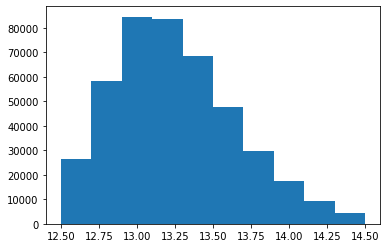

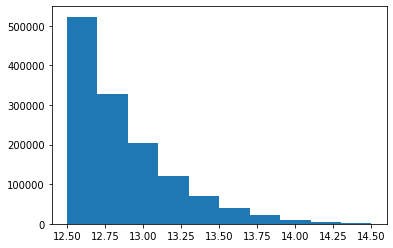

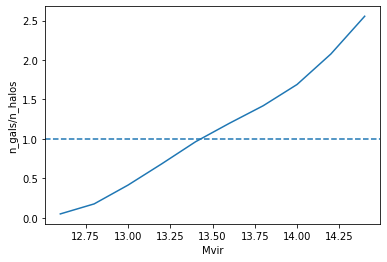

In [42]:
# Number of unique halos between 12.5 and 14.5
# USe halo catalog Mvir here

# Make a array between 12.5 and 14.5 with binwidth 0.2 dex
dm=0.2
mass_bins = np.arange(12.5,14.7,dm)
mass_bin_centers = mass_bins[:-1]+(dm/2)

# Count how many galaxies have Mvir in this bina nd divide by number of unique halos
n_gals, _, _ = plt.hist(np.log10(model_instance.mock.galaxy_table['halo_mvir']), bins=mass_bins)
plt.show()

n_halos, _, _ = plt.hist(np.log10(mass), bins=mass_bins)
plt.show()

# plot mean number versus the array
plt.plot(mass_bin_centers, n_gals/n_halos)
plt.axhline(1, linestyle='--')
plt.xlabel('Mvir')
plt.ylabel('n_gals/n_halos')

plt.show()

### using Lange19 HOD

In [26]:
Lange19model_instance = Lange19_HOD_model(redshift = redshift, cosmology=Planck15, secondary_haloprop_key='halo_nfw_conc') #, conc_mass_model = 'dutton_maccio14')

model_instance.param_dict['logMmin'] = 13.031
model_instance.param_dict['sigma_logM'] = 0.38
model_instance.param_dict['logM0'] = 13.27
model_instance.param_dict['logM1'] = 14.08
model_instance.param_dict['alpha'] = 0.76
#params from https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract

model_instance.populate_mock(halo_catalog)

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


In [27]:
x = model_instance.mock.galaxy_table['x']
y = model_instance.mock.galaxy_table['y']
z = model_instance.mock.galaxy_table['z']
galaxy_positions = return_xyz_formatted_array(x, y, z,
                                              velocity_distortion_dimension ='z',
                                              velocity = model_instance.mock.galaxy_table['vz'],
                                             redshift = redshift, cosmology = Planck15, period =period)

In [28]:
px = model_instance.mock.ptcl_table['x']
py = model_instance.mock.ptcl_table['y']
pz = model_instance.mock.ptcl_table['z']

particle_positions = return_xyz_formatted_array(px, py, pz)

In [30]:
pi_max = 80. #80 h−1 Mpc in Reid et al. https://arxiv.org/pdf/1404.3742.pdf comoving distances
rp_bins = np.logspace(-1,1.25,15)
rp_bin_centers = (rp_bins[:-1] + rp_bins[1:])/2.


wp_all = wp(galaxy_positions, rp_bins, pi_max, period=model_instance.mock.Lbox, num_threads='max')

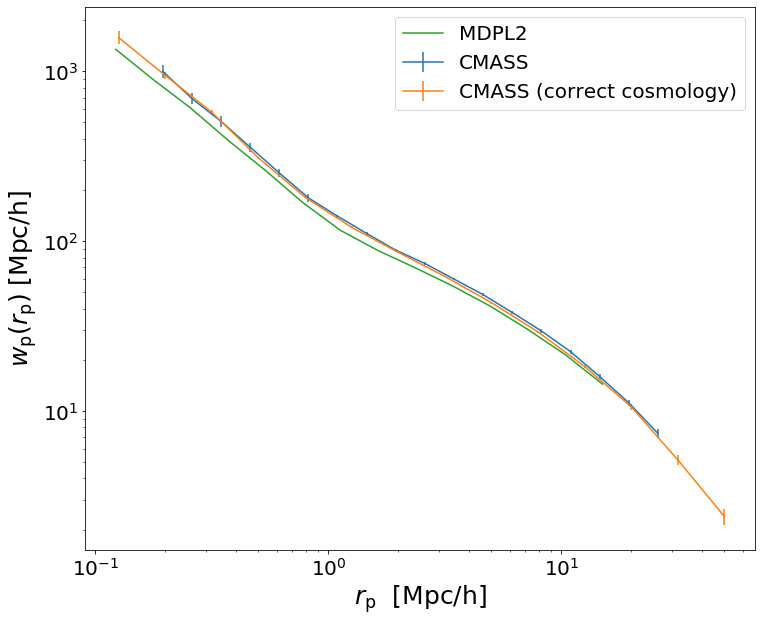

In [31]:
plt.figure(figsize=[12,10])
plt.errorbar(wp_data['rp'],wp_data['wp'], yerr = wp_data['wp_err'], label='CMASS')
plt.errorbar(wp_correct_cosmology_data['rp'],wp_correct_cosmology_data['wp'], yerr = wp_correct_cosmology_data['wp_err'], label='CMASS (correct cosmology)')

plt.plot(rp_bin_centers, wp_all, label=r'MDPL2')

plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$w_{\rm p}(r_{\rm p})$ $\rm{[Mpc/h]}$', fontsize=25)
# plt.title(r'$M_{\ast} > 10^{10.25}M_{\odot}$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.show()

In [32]:
rp_bins = np.logspace(-1, 1, 15)

particle_masses = halo_catalog.particle_mass
period=model_instance.mock.Lbox
downsampling_factor = (halo_catalog.num_ptcl_per_dim**3)/float(len(particle_positions))

rp, ds_in_mpc = delta_sigma(galaxy_positions, particle_positions,
                    particle_masses, downsampling_factor,
                    rp_bins, period, cosmology=Planck15, num_threads='max')

length_unit_conversion = 1e6
ds_in_pc = ds_in_mpc/length_unit_conversion**2

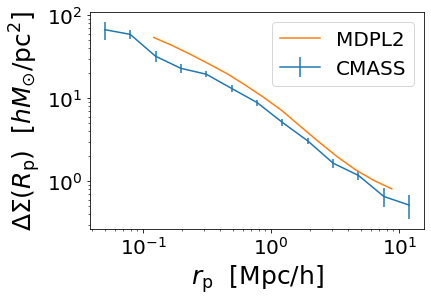

In [34]:
plt.errorbar(ds_data['rp'],ds_data['ds'], yerr = ds_data['ds_err'], label='CMASS')
plt.plot(rp, ds_in_pc, label='MDPL2')
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()